In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../tacotron2/")
sys.path.insert(0, "../waveglow/")

import librosa
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Audio

from audio.vocoders import griffin_lim
from tacotron2.model import Tacotron2
from tacotron2.text import text_to_sequence, sequence_to_text
from waveglow.glow import WaveGlow

In [2]:
import tntorch as tn
import time

In [3]:
# Tacotron 2
TACOTRON_CONFIG=json.load(open('../tacotron2/config.json', 'r'))
TACOTRON_CHECKPT='../checkpoints/tacotron2_statedict.pt'

# Waveglow
WAVEGLOW_CONFIG=json.load(open('../waveglow/config.json', 'r'))
WAVEGLOW_CHECKPT='../checkpoints/waveglow_256channels_ljs_v3.pt'

# Essential
USE_FP16=True
ON_GPU=False
MAX_WAV_VALUE=32768.0
SIGMA=1.1

In [24]:
tacotron2 = Tacotron2(TACOTRON_CONFIG)
checkpt_state_dict = torch.load(TACOTRON_CHECKPT,
                                map_location=lambda storage, loc: storage)['state_dict']
tacotron2.load_state_dict(checkpt_state_dict)
_ = tacotron2.cuda().eval() if ON_GPU else tacotron2.cpu().eval()

print('Number of parameters:', tacotron2.nparams())

Number of parameters: 28193153


In [31]:
waveglow = torch.load(WAVEGLOW_CHECKPT,
                      map_location=lambda storage, loc: storage)['model']
waveglow = waveglow.remove_weightnorm(waveglow)
_ = waveglow.cuda().eval() if ON_GPU else waveglow.cpu().eval()

In [5]:
sum(p.numel() for p in tacotron2.encoder.lstm.parameters() if p.requires_grad), \
sum(p.numel() for p in tacotron2.encoder.convolutions.parameters() if p.requires_grad), \
sum(p.numel() for p in tacotron2.encoder.lstm.parameters() if p.requires_grad) / \
sum(p.numel() for p in tacotron2.encoder.convolutions.parameters() if p.requires_grad)

(1576960, 3936768, 0.4005722460658083)

In [6]:
sum(p.numel() for p in tacotron2.encoder.lstm.parameters() if p.requires_grad) + \
sum(p.numel() for p in tacotron2.decoder.attention_rnn.parameters() if p.requires_grad) + \
sum(p.numel() for p in tacotron2.decoder.decoder_rnn.parameters() if p.requires_grad)

19419136

In [7]:
for key, value in tacotron2.state_dict().items():
    if 'lstm' in key: print(key)

encoder.lstm.weight_ih_l0
encoder.lstm.weight_hh_l0
encoder.lstm.bias_ih_l0
encoder.lstm.bias_hh_l0
encoder.lstm.weight_ih_l0_reverse
encoder.lstm.weight_hh_l0_reverse
encoder.lstm.bias_ih_l0_reverse
encoder.lstm.bias_hh_l0_reverse


### Some pruning

In [8]:
lstm_layers = [p for p in tacotron2.encoder.lstm.parameters()]

In [10]:
def pruning(layer, thr):
    layer_changed = layer.flatten()
    print('Threshold: {}'.format(thr))
    print('Changed parameters: {0:0f}%\n'.format((torch.abs(layer_changed) < thr).sum().item() / layer_changed.size(0) * 100))
    layer_changed = layer_changed.masked_fill(torch.abs(layer_changed) < thr, 0)
    return layer_changed.reshape(layer.shape)

In [11]:
pruned_lstm_layers = [pruning(p, 0.01) for p in lstm_layers]

Threshold: 0.01
Changed parameters: 37.270164%

Threshold: 0.01
Changed parameters: 18.419647%

Threshold: 0.01
Changed parameters: 9.570312%

Threshold: 0.01
Changed parameters: 8.593750%

Threshold: 0.01
Changed parameters: 41.286850%

Threshold: 0.01
Changed parameters: 29.224014%

Threshold: 0.01
Changed parameters: 18.847656%

Threshold: 0.01
Changed parameters: 18.554688%



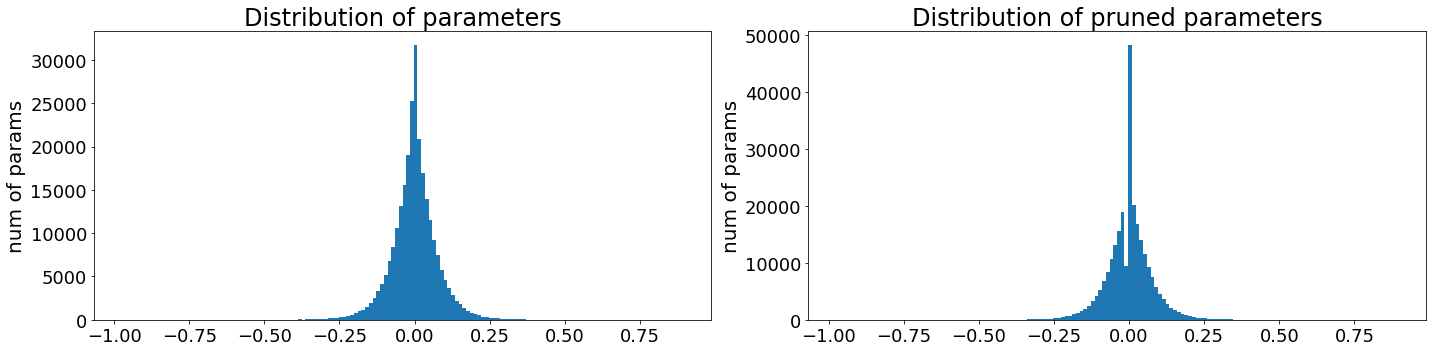

In [12]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(lstm_layers[1].detach().numpy().flatten(), 150);
plt.ylabel('num of params', fontsize=20)
plt.title('Distribution of parameters', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.tight_layout();

plt.subplot(1, 2, 2)
plt.hist(pruned_lstm_layers[1].detach().numpy().flatten(), 150);
plt.ylabel('num of params', fontsize=20)
plt.title('Distribution of pruned parameters', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.tight_layout();

In [161]:
def make_sparse(layers):
    sparse_tensors = []
    with torch.no_grad():
        for i in range(len(layers)):
            sparse_tensors.append(torch.sparse_coo_tensor(layers[i].nonzero().T, 
                                                          layers[i][layers[i].data != 0], 
                                                          layers[i].size()))
    return sparse_tensors

In [162]:
sparse_pruned_lstm_layers = make_sparse(pruned_lstm_layers)

In [165]:
torch.save(lstm_layers[0], 'real')
torch.save({'indices': pruned_lstm_layers[0].nonzero().T, 
            'values': pruned_lstm_layers[0][pruned_lstm_layers[0].data != 0], 
            'size': pruned_lstm_layers[0].size()}, 
           'sparse')

In [122]:
import torch
import torch_sparse
from torch_sparse import coalesce

In [129]:
index = torch.tensor([[0, 7, 1, 2, 8],
                      [0, 2, 1, 0, 1]])
value = torch.Tensor([1, 2, 4, 1, 3])

%timeit torch_sparse.spmm(index, value, 1024, 512, torch.randn((512)))

67.2 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [138]:
%timeit lstm_layers[0] @ torch.randn((512))

35 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [139]:
%timeit pruned_lstm_layers[0] @ torch.randn((512))

36.7 µs ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### How pruning affects prediction quality

In [29]:
texts = ["WaveGlow and L P C Net are accelerated derivatives of WaveNet state-of-the-art model."]
assert len(texts) > 0
texts = [text.strip() for text in texts]
sequences = [np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
             for text in texts]
sequences = [torch.autograd.Variable(torch.from_numpy(sequence)).long()
             for sequence in sequences]

#### $Threshold = 0.01$

In [49]:
pruned_lstm_layers = [pruning(p, 0.01) for p in lstm_layers]

Threshold: 0.01
Changed parameters: 37.270164%

Threshold: 0.01
Changed parameters: 18.419647%

Threshold: 0.01
Changed parameters: 9.570312%

Threshold: 0.01
Changed parameters: 8.593750%

Threshold: 0.01
Changed parameters: 41.286850%

Threshold: 0.01
Changed parameters: 29.224014%

Threshold: 0.01
Changed parameters: 18.847656%

Threshold: 0.01
Changed parameters: 18.554688%



In [50]:
for i, layer in enumerate(tacotron2.encoder.lstm.parameters()):
    layer.data = pruned_lstm_layers[i]

In [51]:
TEXT_IDX = -1
print(sequence_to_text(map(int, list(sequences[TEXT_IDX].squeeze()))))

total_start = datetime.now()

with torch.no_grad():
    tc_start = datetime.now()
    mel_outputs, mel, gate_outputs, alignments = tacotron2.inference(sequences[TEXT_IDX])
    tc_end = datetime.now()
    
    wg_start = datetime.now()
    wave_low = MAX_WAV_VALUE*waveglow.infer(mel, sigma=SIGMA)
    wg_end = datetime.now()
    
total_end = datetime.now()
print('Total inference time:', total_end - total_start)
print('Tacotron 2 inference time:', tc_end - tc_start)
print('Waveglow inference time:', wg_end - wg_start)

waveglow and l p c net are accelerated derivatives of wavenet state-of-the-art model.
Total inference time: 0:00:39.818483
Tacotron 2 inference time: 0:00:02.991543
Waveglow inference time: 0:00:36.826940


#### $Threshold = 0.03$

In [52]:
pruned_lstm_layers = [pruning(p, 0.03) for p in lstm_layers]

Threshold: 0.03
Changed parameters: 71.584892%

Threshold: 0.03
Changed parameters: 42.350388%

Threshold: 0.03
Changed parameters: 27.441406%

Threshold: 0.03
Changed parameters: 27.246094%

Threshold: 0.03
Changed parameters: 75.793648%

Threshold: 0.03
Changed parameters: 57.165146%

Threshold: 0.03
Changed parameters: 45.214844%

Threshold: 0.03
Changed parameters: 45.019531%



In [53]:
for i, layer in enumerate(tacotron2.encoder.lstm.parameters()):
    layer.data = pruned_lstm_layers[i]

In [54]:
TEXT_IDX = -1
print(sequence_to_text(map(int, list(sequences[TEXT_IDX].squeeze()))))

total_start = datetime.now()

with torch.no_grad():
    tc_start = datetime.now()
    mel_outputs, mel, gate_outputs, alignments = tacotron2.inference(sequences[TEXT_IDX])
    tc_end = datetime.now()
    
    wg_start = datetime.now()
    wave_middle = MAX_WAV_VALUE*waveglow.infer(mel, sigma=SIGMA)
    wg_end = datetime.now()
    
total_end = datetime.now()
print('Total inference time:', total_end - total_start)
print('Tacotron 2 inference time:', tc_end - tc_start)
print('Waveglow inference time:', wg_end - wg_start)

waveglow and l p c net are accelerated derivatives of wavenet state-of-the-art model.
Total inference time: 0:00:55.606465
Tacotron 2 inference time: 0:00:03.609450
Waveglow inference time: 0:00:51.997015


#### $Threshold = 0.05$

In [55]:
pruned_lstm_layers = [pruning(p, 0.05) for p in lstm_layers]

Threshold: 0.05
Changed parameters: 86.145973%

Threshold: 0.05
Changed parameters: 59.848785%

Threshold: 0.05
Changed parameters: 41.796875%

Threshold: 0.05
Changed parameters: 41.601562%

Threshold: 0.05
Changed parameters: 89.440727%

Threshold: 0.05
Changed parameters: 75.037384%

Threshold: 0.05
Changed parameters: 68.750000%

Threshold: 0.05
Changed parameters: 68.750000%



In [56]:
for i, layer in enumerate(tacotron2.encoder.lstm.parameters()):
    layer.data = pruned_lstm_layers[i]

In [57]:
TEXT_IDX = -1
print(sequence_to_text(map(int, list(sequences[TEXT_IDX].squeeze()))))

total_start = datetime.now()

with torch.no_grad():
    tc_start = datetime.now()
    mel_outputs, mel, gate_outputs, alignments = tacotron2.inference(sequences[TEXT_IDX])
    tc_end = datetime.now()
    
    wg_start = datetime.now()
    wave_hard = MAX_WAV_VALUE*waveglow.infer(mel, sigma=SIGMA)
    wg_end = datetime.now()
    
total_end = datetime.now()
print('Total inference time:', total_end - total_start)
print('Tacotron 2 inference time:', tc_end - tc_start)
print('Waveglow inference time:', wg_end - wg_start)

waveglow and l p c net are accelerated derivatives of wavenet state-of-the-art model.
Total inference time: 0:00:07.266742
Tacotron 2 inference time: 0:00:00.575460
Waveglow inference time: 0:00:06.691282


### Synthesized audios

In [58]:
print('Low-level pruning.')
Audio(wave_low, rate=22050)

Low-level pruning.


In [59]:
print('Middle-level pruning.')
Audio(wave_middle, rate=22050)

Middle-level pruning.


In [60]:
print('Hard-level pruning.')
Audio(wave_hard, rate=22050)

Hard-level pruning.
